# TensorFlow. 

The API of TensorFlow was developed by the Google brain team. Here, I'll explore some of the content from [Tensorflow's documentation](https://www.tensorflow.org/tutorials/customization/basics). 

When using the libray, you will get a message about *[Advanced Vector Extensions](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)*. Specifically, Tensorflow will let you know that AVX2 FMA CPU instructions will be used for performance critical operations. Tensorflow also reccomends rebuilding the library with compiler flags to enable AVX2 for all operations. 

For brevity, this demonstration will just set an environment flag to hide the warning - CPU optimization is not needed for this demonstration.  

In [1]:
import time
import os
import tempfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

Tensorflow is based on the concept of a *"Tensor"* (a multi-dimensional array). Similar to [NumPy](https://numpy.org/), Tensorflow lets developers create tensor objects with a data type and shape. An added benefit is that tensors can reside in accelerator memory, like a GPU. 

Take a look below at the built-in functions for tensors:

In [3]:
print(tf.math.add(1, 2))
print(tf.math.add([1, 2], [3, 4]))
print(tf.math.square(5))
print(tf.math.reduce_sum([1, 2, 3]))

# Operator overloading is also supported
print(tf.math.square(2) + tf.math.square(3))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)


In [4]:
x = tf.linalg.matmul([[1]], [[2, 3]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)
(1, 2)
<dtype: 'int32'>


tf.Tensors, unlike NumPy arrays are [immutable data structures](https://medium.com/@meghamohan/mutable-and-immutable-side-of-python-c2145cf72747). These two custom Python structures can be converted between each other easily.

Tensors can be explicity converted by calling the .numpy() method - which is computationally cheap when the underyling memory representation is shared. However, since the tf.Tensor might be hosted in GPU memory and our NumPy array is always going to be backed by host memory, the tensor may not be able to be converted.

In [5]:
ndarray = np.ones([4, 4])

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.math.multiply(ndarray, 42)
print(tensor)

print("And NumPy operations convert Tensors to NumPy arrays automatically")
print(np.add(tensor, 2))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())

TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42. 42.]
 [42. 42. 42. 42.]
 [42. 42. 42. 42.]
 [42. 42. 42. 42.]], shape=(4, 4), dtype=float64)
And NumPy operations convert Tensors to NumPy arrays automatically
[[44. 44. 44. 44.]
 [44. 44. 44. 44.]
 [44. 44. 44. 44.]
 [44. 44. 44. 44.]]
The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42. 42.]
 [42. 42. 42. 42.]
 [42. 42. 42. 42.]
 [42. 42. 42. 42.]]


## GPU acceleration

Tensorflow has a major advantage in it's ability to reside in a GPU, which effectively offloads processing strain on the CPU of the host machine.

TensorFlow will automatically decide where to process an operation, copying the tensor between the CPU and GPU as necessary. Tensors that are produced by an operation will typically be backed by the memory of the device it was executed on. I do not have a GPU on my macbook, but you can get the idea - memory can be used more efficiently when running algorithms this way. Better Software will help increase the longevity of a computer's hardware.

In [6]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


In [7]:
def time_matmul(x):
    start = time.time()
    for loop in range(10):
        tf.linalg.matmul(x, x)    
    result = time.time()-start
    print("10 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("CPU:0")
    time_matmul(x)

# Force execution on GPU #0 if available
if tf.config.list_physical_devices("GPU"):
    print("On GPU:")
    with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

On CPU:
10 loops: 209.87ms


## Classification Tasks

There are a lot of tutorials and examples that can be worked through on TensorFlow's website. Below is an [example](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) that looks at a credit card transaction data. The goal is to buid a model that detects fraudulent transactions.

First, set up a simple [matplotlib](https://matplotlib.org/) configuration to help visualize the data:

In [8]:
mpl.rcParams['figure.figsize'] = (10, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Using [Pandas](https://pandas.pydata.org/), the example dataset can be downloaded from Kaggle:

In [9]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Note the class imbalance

In [10]:
raw_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [11]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n\n\tTotal: {}\n\tPositive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:

	Total: 284807
	Positive: 492 (0.17% of total)



### Clean, split and normalize the data

The raw data needs to be cleaned up and analyzed before feeding the prediction model. 

The *Time* and *Amount* columns appear to be too variable, so they are not of use. I'll choose to drop the time column (since it's not clear what it means) and then I'll take the log of the amount column to reduce variability:

In [12]:
# create a copy to preserve the original, clean out unwanted cols
cleaned_df = raw_df.copy()
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

Now split the dataset into **training**, **validation**, and **test** sets. 

The training set is used to "train" the model. The model will be fed these examples and "told" what the correct answer is. 

The validation set is used to [evaluate loss](https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss#:~:text=Loss%20is%20the%20penalty%20for,otherwise%2C%20the%20loss%20is%20greater) and make observations about the model. Models are intentionally not trained with the examples in the validation set so that we know the model is truly making a prediction, and is not explicity instructed (remember getting all those "practice tests" before taking an exam in college? It's like that). 

The test set is used to evaluate performance of the model. Do the predictions on the test set fail or succeed? Take a [performance measure](https://en.wikipedia.org/wiki/Root-mean-square_deviation) with this data set.

In [13]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features with the sklearn StandardScaler method. This sets the mean to 0 and the standard deviation to 1.

In [14]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### Data Distribution
Now compare the distributions of positive and negative examples over a few different features. Good questions to ask yourself at this point are:

- *Do these distributions make sense?* 
- *Can you see the difference between the distributions?*    
    
The answers here are yes and yes! With normalized input, the distributions are concentrated in the +/- 2 range. Positive examples appear to contain a much higher rate of extreme values:

In [15]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

Text(0.5, 0.98, 'Positive distribution')

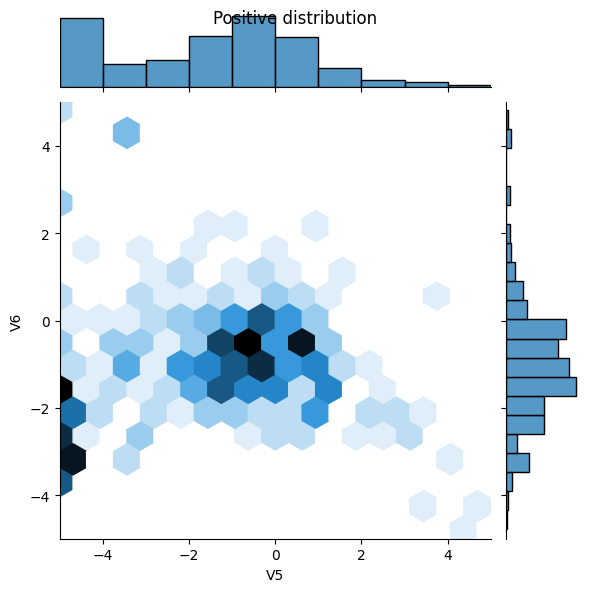

In [16]:
sns.jointplot(x=pos_df['V5'], y=pos_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

Text(0.5, 0.98, 'Negative distribution')

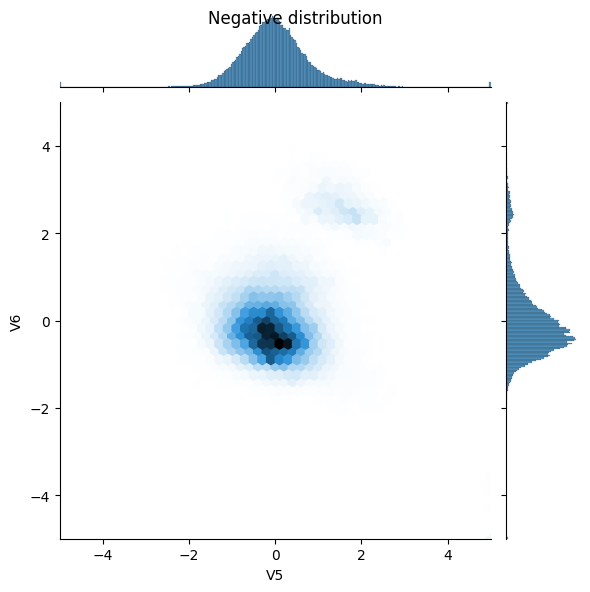

In [17]:
sns.jointplot(x=neg_df['V5'], y=neg_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Negative distribution")

### Define Model & Metrics

This is a basic neural network. The network will have a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer - this is the predicted probability of a transaction being fraudulent:

In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

In [19]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [20]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.predict(train_features[:10])

1/1 [==============================] - 0s 85ms/step


array([[0.54619145],
       [0.87680155],
       [0.31984267],
       [0.71264005],
       [0.6278315 ],
       [0.7345657 ],
       [0.62205917],
       [0.7958705 ],
       [0.70429045],
       [0.654062  ]], dtype=float32)

*Optional*: Set the correct initial bias.

These initial guesses are not great. The dataset is imbalanced. 

To adjust for this, set the output layer's bias. This will help with initial [convergence](https://www.britannica.com/science/convergence-mathematics). With the default bias initialization, the loss should now be about math.log(2) = 0.69314

In [22]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0828


The correct bias to set can be derived from:

$p_0 = pos / (pos + neg) = 1 / (1 + e^{-b_0})$

$b_0 = -log_e(1 / p_0 - 1)$

$b_0 = log_e(pos / neg)$ 

In [23]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Setting the initial bias will enable the model to give much more reasonable guesses. It should be near: pos/total = 0.0018

In [24]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 50ms/step


array([[0.00457737],
       [0.03139198],
       [0.00361748],
       [0.00253493],
       [0.00343442],
       [0.00372259],
       [0.00293383],
       [0.00292449],
       [0.01490666],
       [0.00154849]], dtype=float32)

With this initialization, the initial loss should be approximately:

$-p_0log(p_0) - (1 - p_0)log(1 - p_0) = 0.01317$

In [25]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0178


This initial loss is about 50 times less than it would have been with naive initialization. Now the model doesn't need to spend the first few epochs learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file and load them into each model before training:

In [26]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped. Train the model for 20 epochs (with and without this careful initialization) then compare the losses:

In [27]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [28]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [29]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

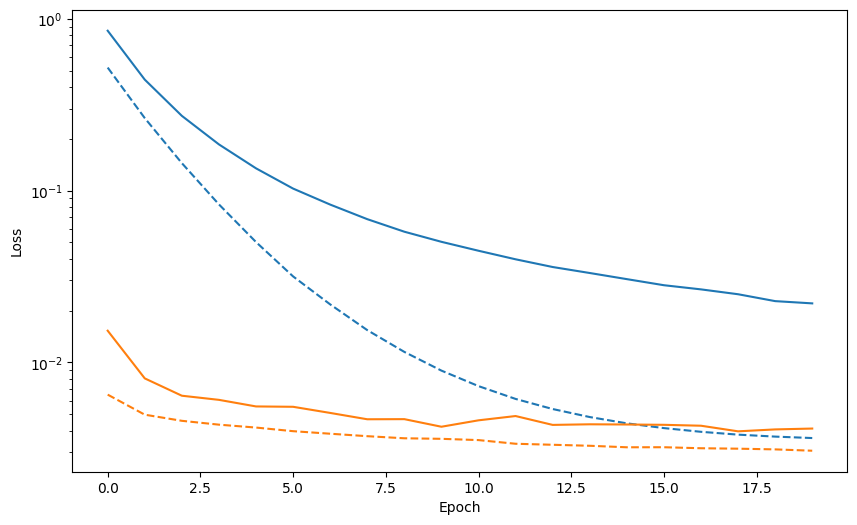

In [30]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss on this problem, careful initialization of the bias will give a clear advantage.

### Train the model

In [31]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 10ms/step - loss: 0.0151 - tp: 102.0000 - fp: 178.0000 - tn: 227268.0000 - fn: 297.0000 - accuracy: 0.9979 - precision: 0.3643 - recall: 0.2556 - auc: 0.7863 - prc: 0.2003 - val_loss: 0.0066 - val_tp: 7.0000 - val_fp: 4.0000 - val_tn: 45499.0000 - val_fn: 59.0000 - val_accuracy: 0.9986 - val_precision: 0.6364 - val_recall: 0.1061 - val_auc: 0.9185 - val_prc: 0.5285
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0085 - tp: 118.0000 - fp: 33.0000 - tn: 181910.0000 - fn: 215.0000 - accuracy: 0.9986 - precision: 0.7815 - recall: 0.3544 - auc: 0.8800 - prc: 0.4459 - val_loss: 0.0049 - val_tp: 35.0000 - val_fp: 7.0000 - val_tn: 45496.0000 - val_fn: 31.0000 - val_accuracy: 0.9992 - val_precision: 0.8333 - val_recall: 0.5303 - val_auc: 0.9226 - val_prc: 0.6388
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0065 - tp: 177.0000 - fp: 33.0000 - tn: 181910.0000 - fn: 156.0000 - accuracy:

### Check training history

In this section, plots are produced to visualize the model's accuracy and loss on both the training and validation set. These are useful to check for [overfitting](https://aws.amazon.com/what-is/overfitting/). Additionally, you can visualize these plots for any of the metrics created above. False negatives are included as an example.

In [32]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        
        elif metric == 'auc':
            plt.ylim([0.8,1])
        
        else:
            plt.ylim([0,1])
            
        plt.legend();

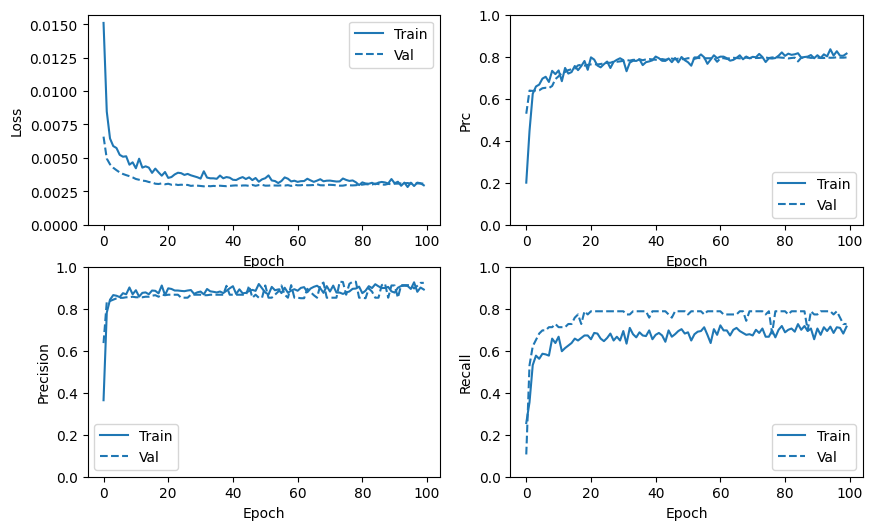

In [33]:
plot_metrics(baseline_history)

### Evaluate metrics

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is used to summarize the actual vs. predicted labels, where the X-axis is the predicted label and the Y-axis is the actual label:

In [34]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 3ms/step


In [35]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

In [36]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

In [37]:
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.003819588804617524
tp :  66.0
fp :  12.0
tn :  56857.0
fn :  27.0
accuracy :  0.9993153214454651
precision :  0.8461538553237915
recall :  0.7096773982048035
auc :  0.9350898861885071
prc :  0.7962247133255005


Legitimate Transactions Detected (True Negatives):  56857
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  66
Total Fraudulent Transactions:  93


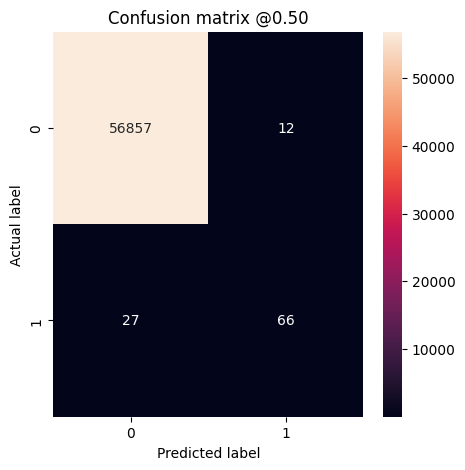

In [38]:
plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, the main diagonal (indicating incorrect predictions) would be zero. 

In this example, the matrix shows relatively few false positives. This means that there were few legitimate transactions that were incorrectly flagged by the model. 

Ideally, there would be fewer false negatives despite the risk of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity (mild customer inconvienance vs potential revenue leakage).

### Plot the ROC

Now, plot the [ROC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). This plot is incredibly useful because it shows the range of performance the model can reach just by tuning the output threshold.

In [39]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

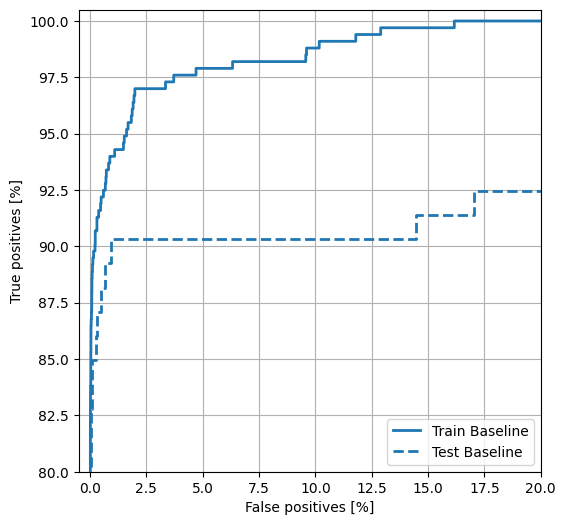

In [40]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

The Area under the interpolated precision-recall curve (AUPRC) is obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

In [41]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

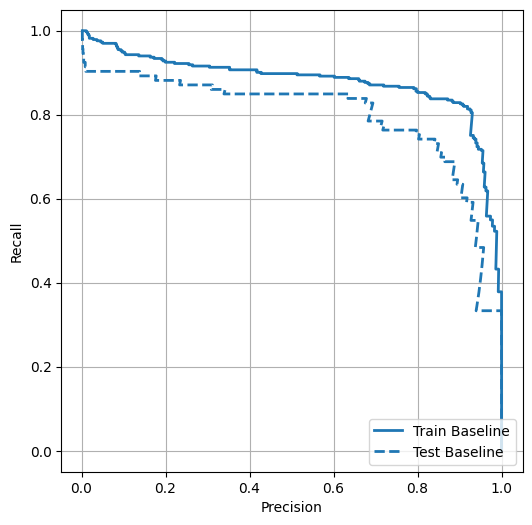

In [42]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as we'd like. 

Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the cost of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may lower customer sentiment.

### Class Weights
**Calculate class weights**

The goal is to identify fraudulent transactions. 

There are not very many positive examples to work with, so you would want to have the classifier heavily weight the few examples that are available in the training and validation sets. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [43]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Retrain and evaluate the model with class weights to see how that impacts predictions:

In [44]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 3s 12ms/step - loss: 1.8558 - tp: 152.0000 - fp: 812.0000 - tn: 238000.0000 - fn: 274.0000 - accuracy: 0.9955 - precision: 0.1577 - recall: 0.3568 - auc: 0.8144 - prc: 0.1568 - val_loss: 0.0156 - val_tp: 38.0000 - val_fp: 100.0000 - val_tn: 45403.0000 - val_fn: 28.0000 - val_accuracy: 0.9972 - val_precision: 0.2754 - val_recall: 0.5758 - val_auc: 0.9587 - val_prc: 0.3399
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 0.6784 - tp: 205.0000 - fp: 1876.0000 - tn: 180067.0000 - fn: 128.0000 - accuracy: 0.9890 - precision: 0.0985 - recall: 0.6156 - auc: 0.9199 - prc: 0.2519 - val_loss: 0.0244 - val_tp: 51.0000 - val_fp: 186.0000 - val_tn: 45317.0000 - val_fn: 15.0000 - val_accuracy: 0.9956 - val_precision: 0.2152 - val_recall: 0.7727 - val_auc: 0.9687 - val_prc: 0.5678
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.4464 - tp: 252.0000 - fp: 2973.0000 - tn: 178970.0000 - fn: 81.0000 - a

### Check training history

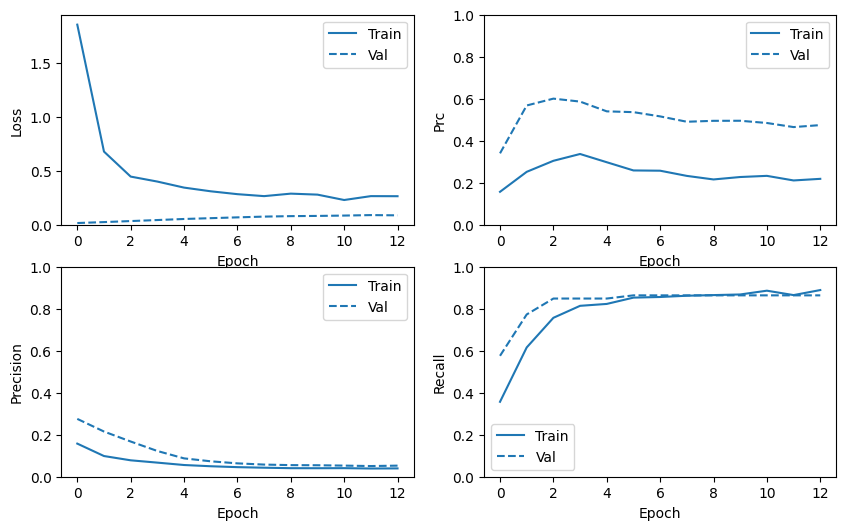

In [45]:
plot_metrics(weighted_history)

### Evaluate metrics

In [46]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


In [47]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

In [48]:
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

loss :  0.033733926713466644
tp :  77.0
fp :  319.0
tn :  56550.0
fn :  16.0
accuracy :  0.994118869304657
precision :  0.1944444477558136
recall :  0.8279569745063782
auc :  0.9673283100128174
prc :  0.5880330204963684


Legitimate Transactions Detected (True Negatives):  56550
Legitimate Transactions Incorrectly Detected (False Positives):  319
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  77
Total Fraudulent Transactions:  93


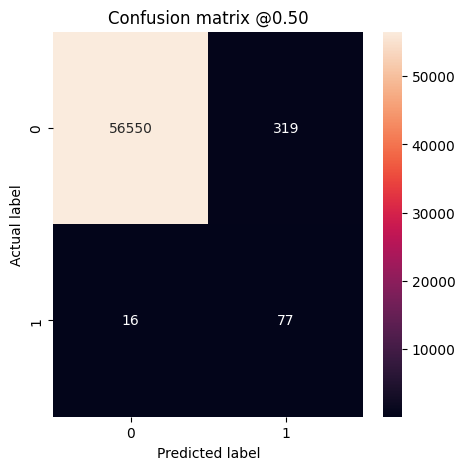

In [49]:
plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). 

Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

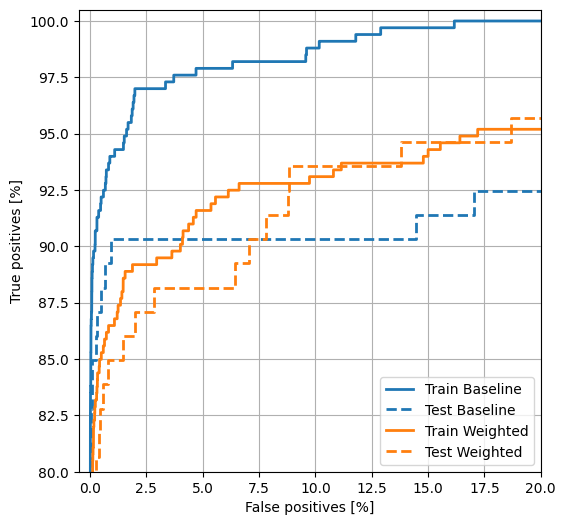

In [50]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

### Plot the AUPRC

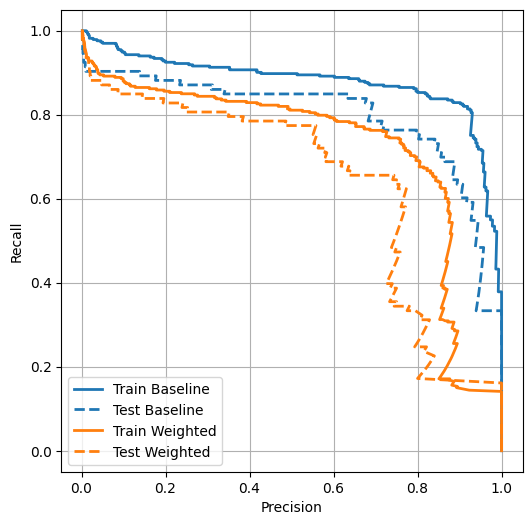

In [51]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower left');

### Oversampling
**Oversample the minority class**

A related approach would be to resample the dataset by oversampling the minority class.

In [52]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

Using NumPy, balance the dataset manually by choosing the right number of random indices from the positive examples:

In [53]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181943, 29)

In [54]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363886, 29)

**Using tf.data**

Using tf.data, the easiest way to produce balanced examples is to start with a positive and a negative dataset then merge them. See the [tf.data guide](https://www.tensorflow.org/guide/data) for more examples.

In [55]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

In [56]:
pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides (feature, label) pairs:

In [57]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [ 0.02967295  1.12313667 -2.67879099  2.88823598 -0.57145484 -0.21910932
 -1.8448085   0.98776696 -0.71359335 -3.55218847  2.9302815  -3.61452327
 -1.7352293  -5.         -0.37426768 -2.93451495 -0.60550244  1.32396762
  2.88218232  0.65451298  0.84530441  1.10183789  0.20616086  0.47713483
 -0.70295821  0.06528335  1.05982556  0.33850093  0.7164858 ]

Label:  1


Merge the two together using tf.data.Dataset.sample_from_datasets:

In [58]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [59]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.4912109375


To use this dataset, you'll need the number of steps per epoch. The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [60]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Train the model with the resampled data set instead of using class weights:

In [61]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 24s 79ms/step - loss: 0.4719 - tp: 252916.0000 - fp: 99076.0000 - tn: 242149.0000 - fn: 32165.0000 - accuracy: 0.7905 - precision: 0.7185 - recall: 0.8872 - auc: 0.9131 - prc: 0.9261 - val_loss: 0.3170 - val_tp: 57.0000 - val_fp: 1639.0000 - val_tn: 43864.0000 - val_fn: 9.0000 - val_accuracy: 0.9638 - val_precision: 0.0336 - val_recall: 0.8636 - val_auc: 0.9543 - val_prc: 0.6997
Epoch 2/100
278/278 [==============================] - 23s 83ms/step - loss: 0.2127 - tp: 261164.0000 - fp: 18534.0000 - tn: 266645.0000 - fn: 23001.0000 - accuracy: 0.9270 - precision: 0.9337 - recall: 0.9191 - auc: 0.9745 - prc: 0.9802 - val_loss: 0.1594 - val_tp: 57.0000 - val_fp: 967.0000 - val_tn: 44536.0000 - val_fn: 9.0000 - val_accuracy: 0.9786 - val_precision: 0.0557 - val_recall: 0.8636 - val_auc: 0.9572 - val_prc: 0.7067
Epoch 3/100
278/278 [==============================] - 28s 100ms/step - loss: 0.1633 - tp: 263726.0000 - fp: 10757.0000 - tn: 2

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

However, training the model with batches provides a smoother gradient signal. Instead of each positive example being shown in one batch with a large weight, they're now shown in many different batches each time with a small weight.

This smoother gradient signal makes it a lot easier to train the model.

### Check training history

Note that the distributions of metrics is different here because the training data has a different distribution from the validation and test data.

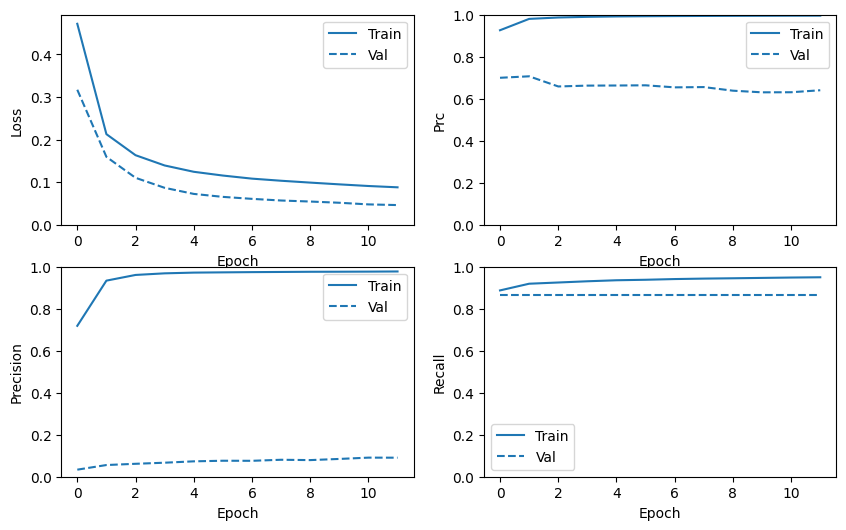

In [62]:
plot_metrics(resampled_history)

### Re-train

Because training is easier on the balanced data, the above training procedure may overfit quickly. So break up the epochs to give the tf.keras.callbacks.EarlyStopping finer control over when to stop training.

In [63]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 5s 118ms/step - loss: 1.1108 - tp: 13858.0000 - fp: 14899.0000 - tn: 50877.0000 - fn: 6895.0000 - accuracy: 0.7481 - precision: 0.4819 - recall: 0.6678 - auc: 0.8348 - prc: 0.6683 - val_loss: 1.0738 - val_tp: 63.0000 - val_fp: 37193.0000 - val_tn: 8310.0000 - val_fn: 3.0000 - val_accuracy: 0.1837 - val_precision: 0.0017 - val_recall: 0.9545 - val_auc: 0.8516 - val_prc: 0.0160
Epoch 2/1000
20/20 [==============================] - 2s 85ms/step - loss: 0.7750 - tp: 16709.0000 - fp: 13726.0000 - tn: 6768.0000 - fn: 3757.0000 - accuracy: 0.5732 - precision: 0.5490 - recall: 0.8164 - auc: 0.7509 - prc: 0.8213 - val_loss: 0.9796 - val_tp: 65.0000 - val_fp: 34598.0000 - val_tn: 10905.0000 - val_fn: 1.0000 - val_accuracy: 0.2407 - val_precision: 0.0019 - val_recall: 0.9848 - val_auc: 0.9431 - val_prc: 0.1144
Epoch 3/1000
20/20 [==============================] - 3s 138ms/step - loss: 0.6352 - tp: 17977.0000 - fp: 12526.0000 - tn: 7943.0000 - 

### Re-check training history

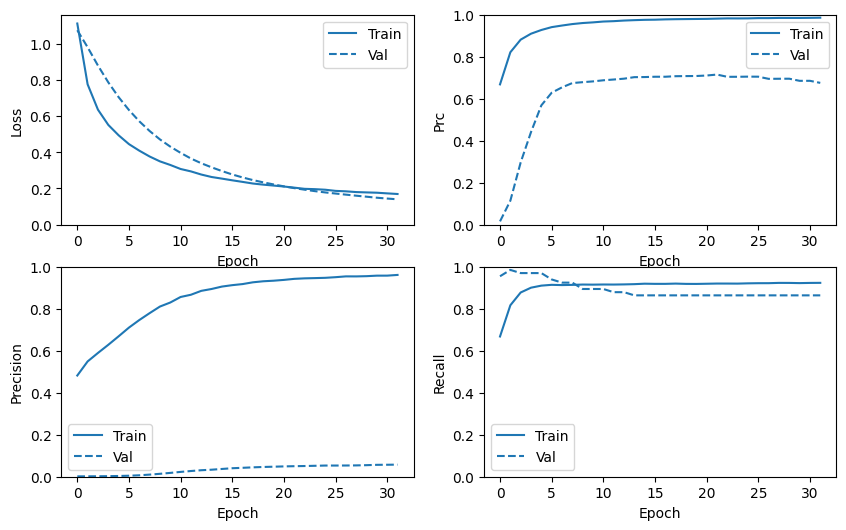

In [64]:
plot_metrics(resampled_history)

### Evaluate metrics

In [65]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 2ms/step


In [66]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

In [67]:
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)

loss :  0.20213204622268677
tp :  83.0
fp :  1322.0
tn :  55547.0
fn :  10.0
accuracy :  0.9766159653663635
precision :  0.05907473340630531
recall :  0.8924731016159058
auc :  0.9587807059288025
prc :  0.6759447455406189


Legitimate Transactions Detected (True Negatives):  55547
Legitimate Transactions Incorrectly Detected (False Positives):  1322
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  83
Total Fraudulent Transactions:  93


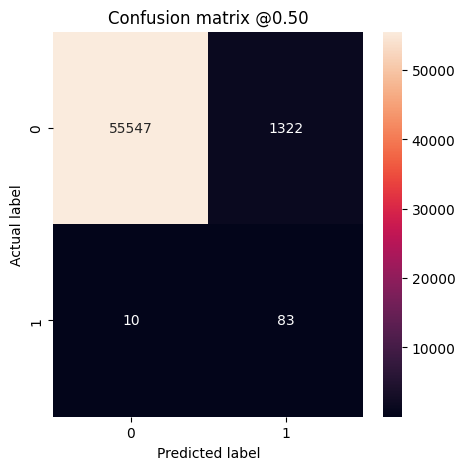

In [68]:
plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

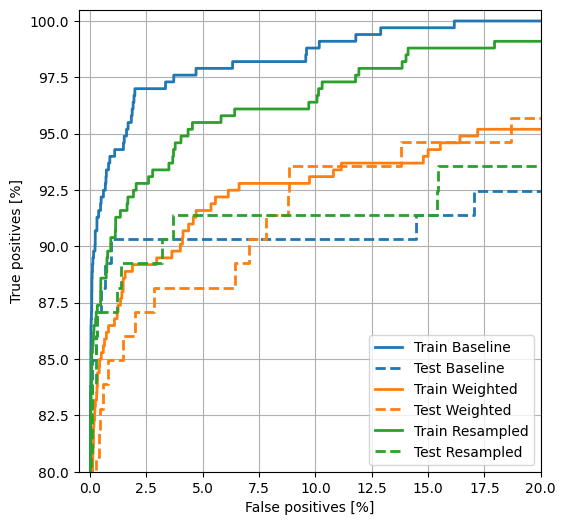

In [69]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

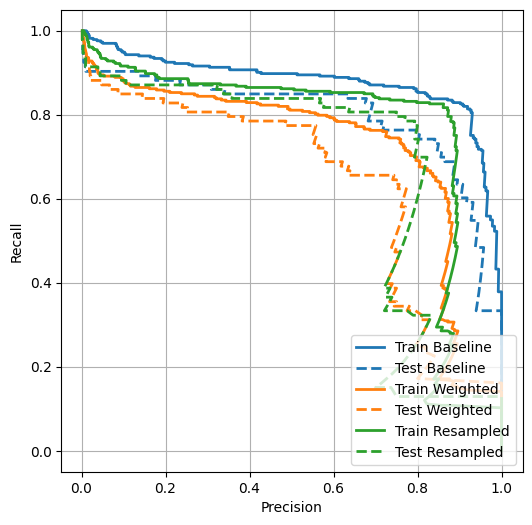

In [70]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### What Now?

Classification from imbalanced data is a really difficult task. 

Always start with the data, do an exploratory analysis, and try to come up with features that are relevant to classifying the given example. It's important to always keep the model's context and tradeoffs between different kinds of errors in mind.